<h1>Projet 3 : Développer un moteur de recommandation de films</h1>


# 1. Libraries

In [560]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
import missingno as msno
import scipy.stats as stats
from fancyimpute import KNN
from collections import Counter
from statsmodels import api as sm
from feature_engine.outlier_removers import Winsorizer
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from scipy.spatial import distance
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

# 2. Data Set

In [561]:
movie_model = pd.read_csv("cleanmovie_data.csv")
del movie_model["Unnamed: 0"]
movie_model.head()

,movie_title,France,UK,USA,English,French,Action,Adventure,Animation,Biography,...,Zal Batmanglij,Zelda Rubinstein,Zheng Xu,Zinedine Soualem,Zoe Kazan,Zoey Deutch,Zooey Deschanel,Zoë Bell,Zoë Kravitz,Óscar Jaenada
0,Fight Valley,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yoga Hosers,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The 5th Wave,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Boss,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Secret Life of Pets,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [562]:
movie_model.shape

(4797, 3186)

In [563]:
movie_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 3186 entries, movie_title to Óscar Jaenada
dtypes: float64(4), int64(3181), object(1)
memory usage: 116.6+ MB


In [564]:
movie_model['movie_title'] = [i.replace('\xa0','') for i in list(movie_model['movie_title'])]

In [ ]:
#Find the index from the movie

In [566]:
movie_model['movie_title'].tolist().index('Avatar')

1523

In [ ]:
#Find the movie from the index

In [568]:
movie_model['movie_title'][4568]

'Superman'

# 3. Movies Recommendation Models

## 3.1 KNN

### 3.1.1 KNN's Libraries

In [569]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors

### 3.1.2  Features Scaling 

In [570]:
movie_model_num = movie_model.iloc[:, 1:3186]
movie_model_num.head()

,France,UK,USA,English,French,Action,Adventure,Animation,Biography,Comedy,...,Zal Batmanglij,Zelda Rubinstein,Zheng Xu,Zinedine Soualem,Zoe Kazan,Zoey Deutch,Zooey Deschanel,Zoë Bell,Zoë Kravitz,Óscar Jaenada
0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [571]:
movie_model_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Columns: 3185 entries, France to Óscar Jaenada
dtypes: float64(4), int64(3181)
memory usage: 116.6 MB


In [572]:
sc = StandardScaler()
movie_model_num_sc = sc.fit_transform(movie_model_num.loc[:, ['title_year', 'duration', 'facenumber_in_poster',
'aspect_ratio', 'budget', 'gross', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score', 
'movie_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 
'actor_2_facebook_likes', 'actor_3_facebook_likes']])

In [573]:
movie_model_num_sc= pd.DataFrame(movie_model_num_sc)
movie_model_num_sc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.090759,-0.927506,1.840725,-0.432860,0.051406,1.420117,-0.962626,-1.132986,-1.261955,-1.525521,0.834479,-0.601610,0.224177,-0.647028,0.240827,-0.271623
1,1.090759,-1.022510,3.814635,0.546798,-0.949805,1.167329,-0.949249,-1.143977,-0.971144,-1.728006,-0.561492,1.415067,-0.709818,1.878904,1.281377,2.041879
2,1.090759,0.117542,-0.791155,0.956102,0.552012,-0.221875,-0.020651,0.295847,0.623301,-1.323037,1.046666,1.472336,-0.661674,1.585513,1.384494,1.104248
3,1.090759,-0.499986,-0.133185,-0.846596,0.142425,0.493870,-0.675678,-0.638390,0.222183,-1.221795,-0.561492,1.895138,1.841817,2.271647,0.693919,-0.455073
4,1.090759,-1.070012,-0.791155,-0.846596,2.235866,1.500082,-0.549820,-0.314155,0.332491,0.296838,0.355661,-0.317857,-0.603901,-0.610114,1.084516,1.175589


In [574]:
movie_model_num_sc.columns = ['title_year', 'duration', 'facenumber_in_poster',
'aspect_ratio', 'budget', 'gross', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score', 
'movie_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 
'actor_2_facebook_likes', 'actor_3_facebook_likes']

In [575]:
movie_model_num_sc.head()

,title_year,duration,facenumber_in_poster,aspect_ratio,budget,gross,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,1.090759,-0.927506,1.840725,-0.432860,0.051406,1.420117,-0.962626,-1.132986,-1.261955,-1.525521,0.834479,-0.601610,0.224177,-0.647028,0.240827,-0.271623
1,1.090759,-1.022510,3.814635,0.546798,-0.949805,1.167329,-0.949249,-1.143977,-0.971144,-1.728006,-0.561492,1.415067,-0.709818,1.878904,1.281377,2.041879
2,1.090759,0.117542,-0.791155,0.956102,0.552012,-0.221875,-0.020651,0.295847,0.623301,-1.323037,1.046666,1.472336,-0.661674,1.585513,1.384494,1.104248
3,1.090759,-0.499986,-0.133185,-0.846596,0.142425,0.493870,-0.675678,-0.638390,0.222183,-1.221795,-0.561492,1.895138,1.841817,2.271647,0.693919,-0.455073
4,1.090759,-1.070012,-0.791155,-0.846596,2.235866,1.500082,-0.549820,-0.314155,0.332491,0.296838,0.355661,-0.317857,-0.603901,-0.610114,1.084516,1.175589


In [576]:
movie_model_num=movie_model_num.drop(movie_model_num[['title_year', 'duration', 'facenumber_in_poster',
'aspect_ratio', 'budget', 'gross', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score', 
'movie_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 
'actor_2_facebook_likes', 'actor_3_facebook_likes']], axis=1)
movie_model_num.head()

,France,UK,USA,English,French,Action,Adventure,Animation,Biography,Comedy,...,Zal Batmanglij,Zelda Rubinstein,Zheng Xu,Zinedine Soualem,Zoe Kazan,Zoey Deutch,Zooey Deschanel,Zoë Bell,Zoë Kravitz,Óscar Jaenada
0,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [577]:
movie_model_num_1=pd.concat([movie_model_num, movie_model_num_sc], axis=1)
movie_model_num_1.head()

,France,UK,USA,English,French,Action,Adventure,Animation,Biography,Comedy,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,0,0,1,1,0,1,0,0,0,0,...,-0.962626,-1.132986,-1.261955,-1.525521,0.834479,-0.601610,0.224177,-0.647028,0.240827,-0.271623
1,0,0,1,1,0,0,0,0,0,1,...,-0.949249,-1.143977,-0.971144,-1.728006,-0.561492,1.415067,-0.709818,1.878904,1.281377,2.041879
2,0,0,1,1,0,1,1,0,0,0,...,-0.020651,0.295847,0.623301,-1.323037,1.046666,1.472336,-0.661674,1.585513,1.384494,1.104248
3,0,0,1,1,0,0,0,0,0,1,...,-0.675678,-0.638390,0.222183,-1.221795,-0.561492,1.895138,1.841817,2.271647,0.693919,-0.455073
4,0,0,0,1,0,0,0,1,0,1,...,-0.549820,-0.314155,0.332491,0.296838,0.355661,-0.317857,-0.603901,-0.610114,1.084516,1.175589


### 3.1.3 KNN implementation

In [578]:
#model_knn = NearestNeighbors(n_neighbors=6, metric='cosine')
model_knn = NearestNeighbors(n_neighbors=6, metric='manhattan')
#model_knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
model_knn.fit(movie_model_num_1)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

### 3.1.4 Similarity Matrix

In [579]:
distances, indices = model_knn.kneighbors(movie_model_num_1)

In [580]:
print(distances, indices)

[[ 0.         10.06692698 10.48878882 10.49921981 10.78926776 10.99670583]
 [ 0.         18.79791523 19.26844412 19.28257299 19.47350676 19.64654159]
 [ 0.         13.84339924 13.96652108 14.34732942 14.63197142 14.73049544]
 ...
 [ 0.          8.663823   10.57928203 13.03586419 13.27320106 13.59813847]
 [ 0.         12.60534565 17.72356831 17.83677655 18.27726638 19.18534408]
 [ 0.         12.35919193 15.53747297 15.88524545 16.22667565 16.86331532]] [[   0 1101  233  373   10  195]
 [   1  368  478  559  138  264]
 [   2 3973   71  134 2248   96]
 ...
 [4794 4788 4792 4733 4787 4751]
 [4795 2080   64 2048  526 2125]
 [4796   64  151 1893 1589 1525]]


In [581]:
print(distances.shape)
print(indices.shape)

(4797, 6)
(4797, 6)


### 3.1.5  Similar Movies Request With KNN

In [495]:
def similar_movies_knn(id):
    
    dict_movie = {}
    for id in indices[id]: 
        dict_movie[id]=movie_model.iloc[id]['movie_title']
        
    return  'The movie chosen and the 5 similar ones:', dict_movie

In [582]:
similar_movies_knn(id=268)

('The movie chosen and the 5 similar ones:',
 {268: 'Mission: Impossible - Rogue Nation',
  1037: 'Mission: Impossible - Ghost Protocol',
  933: 'The Bourne Legacy',
  424: 'Edge of Tomorrow',
  3432: 'Mission: Impossible II',
  2243: 'Mission: Impossible III'})

In [583]:
indices

array([[   0, 1101,  233,  373,   10,  195],
       [   1,  368,  478,  559,  138,  264],
       [   2, 3973,   71,  134, 2248,   96],
       ...,
       [4794, 4788, 4792, 4733, 4787, 4751],
       [4795, 2080,   64, 2048,  526, 2125],
       [4796,   64,  151, 1893, 1589, 1525]], dtype=int64)

In [584]:
movies_indices_neighbors = pd.DataFrame(indices)
movies_indices_neighbors.columns=['id_movie','nb1','nb2','nb3','nb4','nb5']
movies_indices_neighbors.head()  

,id_movie,nb1,nb2,nb3,nb4,nb5
0,0,1101,233,373,10,195
1,1,368,478,559,138,264
2,2,3973,71,134,2248,96
3,3,317,76,103,1488,3316
4,4,190,1129,418,1323,2044


In [585]:
movies_indices_neighbors.to_csv('movies_indices_neighbors.csv')

In [586]:
movie_title = movie_model[['movie_title']]
movie_title.head()

,movie_title
0,Fight Valley
1,Yoga Hosers
2,The 5th Wave
3,The Boss
4,The Secret Life of Pets


In [587]:
movie_title.to_csv('movie_title.csv')

## 3.2 K-Means Clustering

### 3.2.1 K-Means Libraries

In [606]:
from sklearn.cluster import KMeans

### 3.2.2 K-Means Implementation

In [607]:
kmeans_model = KMeans(n_clusters = 50, init = 'k-means++')

In [608]:
y_kmeans = kmeans_model.fit_predict(movie_model_num_1) #l'utilisation du kmeans avec DF normalisé donne une répartition des clusters


### 3.2.3 Cluster Centers

In [609]:
kmeans_model.cluster_centers_

array([[ 0.02352941,  0.12941176,  0.70588235, ..., -0.61894984,
        -0.79579011, -0.83268303],
       [ 0.02631579,  0.21052632,  0.63157895, ...,  1.6232869 ,
        -0.25642387, -0.63730052],
       [ 0.02564103,  0.07692308,  0.83333333, ...,  1.42885155,
         0.9024377 ,  0.86160844],
       ...,
       [ 0.02739726,  0.07534247,  0.63013699, ..., -0.71010909,
        -1.40102891, -1.14703389],
       [ 0.11842105,  0.09210526,  0.28947368, ..., -0.65021675,
        -0.86464498, -0.84838961],
       [ 0.02013423,  0.08053691,  0.80536913, ..., -0.65878257,
        -0.97424971, -0.90979774]])

In [610]:
kmeans_model.cluster_centers_.shape

(50, 3185)

### 3.2.4 Movie Labels

In [611]:
movie_model_label = pd.DataFrame({"label":y_kmeans}, index=movie_model['movie_title']).rename_axis('movie_title').reset_index()
movie_model_label=pd.concat([movie_model_label, movie_model_num_1], axis=1)
movie_model_label.head()

,movie_title,label,France,UK,USA,English,French,Action,Adventure,Animation,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,42,0,0,1,1,0,1,0,0,...,-0.962626,-1.132986,-1.261955,-1.525521,0.834479,-0.601610,0.224177,-0.647028,0.240827,-0.271623
1,Yoga Hosers,2,0,0,1,1,0,0,0,0,...,-0.949249,-1.143977,-0.971144,-1.728006,-0.561492,1.415067,-0.709818,1.878904,1.281377,2.041879
2,The 5th Wave,22,0,0,1,1,0,1,1,0,...,-0.020651,0.295847,0.623301,-1.323037,1.046666,1.472336,-0.661674,1.585513,1.384494,1.104248
3,The Boss,31,0,0,1,1,0,0,0,0,...,-0.675678,-0.638390,0.222183,-1.221795,-0.561492,1.895138,1.841817,2.271647,0.693919,-0.455073
4,The Secret Life of Pets,11,0,0,0,1,0,0,0,1,...,-0.549820,-0.314155,0.332491,0.296838,0.355661,-0.317857,-0.603901,-0.610114,1.084516,1.175589


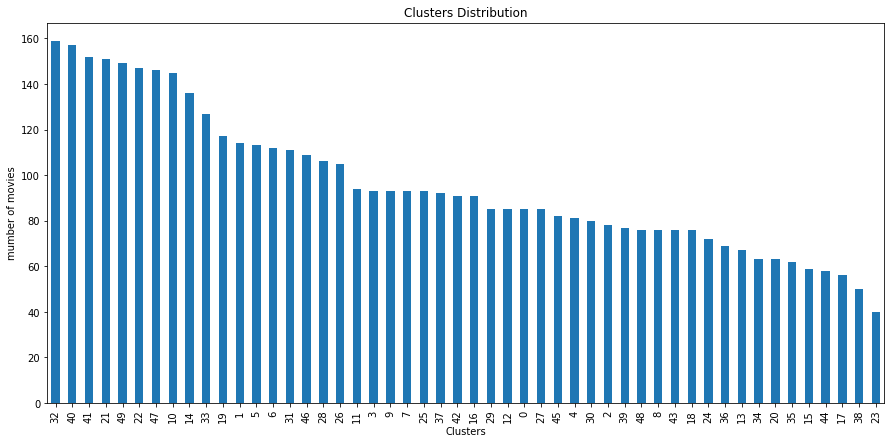

In [612]:
plot_distribution_clusters = movie_model_label['label'].value_counts().plot.bar(figsize=(15, 7))
plot_distribution_clusters.set_title('Clusters Distribution')
plot_distribution_clusters.set_xlabel('Clusters')
plot_distribution_clusters.set_ylabel('mumber of movies')
plt.draw()

### 3.2.5  Similar Movies Request With K-Means

In [613]:
def similar_movies_kmeans(label, movie):
    #print('5 similar movies with :', movie_model_label['movie_title'][movie], movie_model_label['label'][movie])
    
    movie_cluster=label[movie]
    indices_1=np.where(label==movie_cluster)
    indices_1=indices_1[0]
    (id for id in indices_1 if id==movie)
    print('number of cluster',movie_model_label['label'][movie], ':', len(indices_1))
    indices_2=indices_1
    
    similar_movies = movie_model_label.iloc[indices_2]
    return similar_movies

In [618]:
similar_movies = similar_movies_kmeans(y_kmeans, 96)
#similar_movies.head(15)
similar_movies = similar_movies.reset_index() 
similar_movies.head(91)

number of cluster 45 : 82


,index,movie_title,label,France,UK,USA,English,French,Action,Adventure,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,80,Captain America: Civil War,45,0,0,1,1,0,1,1,...,1.247184,0.526658,1.044476,1.714229,0.810747,2.551495,0.195290,2.134420,-0.037278,0.655816
1,96,Batman v Superman: Dawn of Justice,45,0,0,1,1,0,1,1,...,0.298614,-0.061361,0.322463,0.398080,-0.350701,1.999778,-0.709818,1.311060,1.375120,1.861826
2,110,The Martian,45,0,0,1,1,0,0,1,...,0.219671,0.130982,0.252267,1.612987,-0.533573,0.866296,-0.709818,1.036607,0.762664,-0.091571
3,300,Avengers: Age of Ultron,45,0,0,1,1,0,1,1,...,0.355040,0.872876,0.853945,1.005533,-0.364660,2.578951,-0.709818,2.820554,-0.015405,0.224370
4,322,Interstellar,45,0,0,1,1,0,0,1,...,0.624915,0.196928,0.853945,2.119198,-0.286486,2.829120,-0.555757,0.762153,1.147011,0.676199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,4256,The Godfather: Part III,45,0,0,1,1,0,0,0,...,1.857093,1.829095,-0.219047,1.106776,-0.561492,1.115876,-0.709818,1.173833,1.384494,1.664788
78,4298,Indiana Jones and the Last Crusade,45,0,0,1,1,0,1,1,...,2.239041,1.455400,0.172043,1.815471,-0.561492,0.636865,-0.584644,0.762153,0.897029,0.139439
79,4458,Star Wars: Episode VI - Return of the Jedi,45,0,0,1,1,0,1,1,...,1.694104,2.389637,0.653385,1.916713,-0.522405,0.727011,-0.353552,0.762153,1.384494,0.356861
80,4547,Apocalypse Now,45,0,0,1,1,0,0,0,...,1.775556,2.032429,1.295175,2.017955,0.147661,2.101472,-0.709818,0.762153,0.934527,1.178987


In [620]:
#KNN filter
def similar_movies_knn_1(id):
    model_knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model_knn.fit(similar_movies.iloc[:, 3:])
    distances, indices = model_knn.kneighbors(similar_movies.iloc[:, 3:])
    movies_indices_neighbors_1 = pd.DataFrame(indices).values
    dict_movie = []
    for id in movies_indices_neighbors_1[id]: 
        dict_movie.append(similar_movies.iloc[id]['movie_title'])
    return  '5 similar movies to the first on the list:', dict_movie

In [622]:
similar_movies_knn_1(1)

('5 similar movies to the first on the list:',
 ['Batman v Superman: Dawn of Justice',
  'Man of Steel',
  'Superman Returns',
  'Iron Man 3',
  'Interstellar',
  'Star Trek Into Darkness'])

## 3.3 Agglomerative Hierarchical Clustering

### 3.3.1 Agglomerative HC Libraries

In [624]:
import scipy.cluster.hierarchy as sch

In [625]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [626]:
from scipy.spatial import distance_matrix

### 3.3.2 Dendrogram

In [ ]:
#Test several distance and method

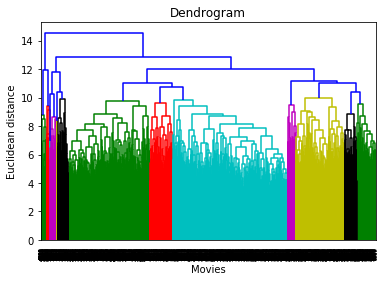

In [627]:
#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1, method= 'ward'))

#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1, method= 'average', metric='euclidean'))
#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1, method= 'average', metric='manhattan'))
#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1, method= 'average', metric='cosine'))

dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1, method= 'complete', metric='euclidean'))
#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1,method= 'complete', metric='manhattan'))
#dendrogram_1= sch.dendrogram(sch.linkage(movie_model_num_1,method= 'complete', metric='cosine'))

plt.title('Dendrogram')
plt.xlabel('Movies')
plt.ylabel('Euclidean distance')
plt.show()        
#plt.savefig("Dendrogram ward", bbox_inches="tight")

In [628]:
from sklearn.cluster import AgglomerativeClustering

### 3.3.3 HC Implementation

In [629]:
hc = AgglomerativeClustering(n_clusters = 50, affinity = 'euclidean', linkage = 'complete')
#hc = AgglomerativeClustering(n_clusters = 50, affinity = 'euclidean', linkage = 'ward')
#hc = AgglomerativeClustering(n_clusters = 300, affinity = 'cosine', linkage = 'average')
#hc = AgglomerativeClustering(n_clusters = 300, affinity = 'euclidean', linkage = 'average')
#hc = AgglomerativeClustering(n_clusters = 300, affinity = 'euclidean', linkage = 'complete')
#hc = AgglomerativeClustering(n_clusters = 50, affinity = 'cosine', linkage = 'complete')

In [630]:
y_hc = hc.fit_predict(movie_model_num_1)

### 3.3.4 Movie Labels

In [631]:
#movie_model_label_hc = pd.DataFrame({"label_hc":y_hc}, index=movie_model['movie_title']).rename_axis('movie_title').reset_index()
#movie_model_label_hc.head()
movie_model_label_hc = pd.DataFrame({"label_hc":y_hc}, index=movie_model['movie_title']).rename_axis('movie_title').reset_index()
movie_model_label_hc=pd.concat([movie_model_label_hc, movie_model_num_1], axis=1)
movie_model_label_hc.head()

,movie_title,label_hc,France,UK,USA,English,French,Action,Adventure,Animation,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,6,0,0,1,1,0,1,0,0,...,-0.962626,-1.132986,-1.261955,-1.525521,0.834479,-0.601610,0.224177,-0.647028,0.240827,-0.271623
1,Yoga Hosers,21,0,0,1,1,0,0,0,0,...,-0.949249,-1.143977,-0.971144,-1.728006,-0.561492,1.415067,-0.709818,1.878904,1.281377,2.041879
2,The 5th Wave,36,0,0,1,1,0,1,1,0,...,-0.020651,0.295847,0.623301,-1.323037,1.046666,1.472336,-0.661674,1.585513,1.384494,1.104248
3,The Boss,12,0,0,1,1,0,0,0,0,...,-0.675678,-0.638390,0.222183,-1.221795,-0.561492,1.895138,1.841817,2.271647,0.693919,-0.455073
4,The Secret Life of Pets,0,0,0,0,1,0,0,0,1,...,-0.549820,-0.314155,0.332491,0.296838,0.355661,-0.317857,-0.603901,-0.610114,1.084516,1.175589


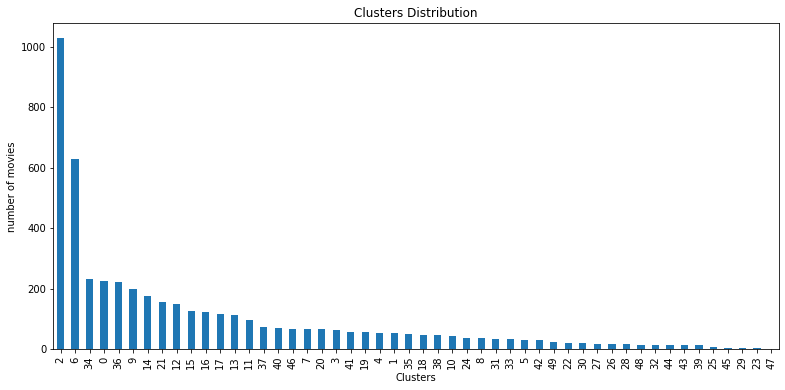

In [633]:
plot_distribution_clusters_1 = movie_model_label_hc['label_hc'].value_counts().plot.bar(figsize=(13,6))
plot_distribution_clusters_1.set_title('Clusters Distribution')
plot_distribution_clusters_1.set_xlabel('Clusters')
plot_distribution_clusters_1.set_ylabel('number of movies')
plt.draw()

### 3.3.5  Similar Movies Request With HC

In [634]:
def similar_movies_hc_ward_euc(label_hc, movie_hc):
    #print('5 similar movies with :', movie_model_label['movie_title'][movie], movie_model_label['label'][movie])
    
    movie_cluster_hc=label_hc[movie_hc]
    indices_2=np.where(label_hc==movie_cluster_hc)
    indices_2=indices_2[0]
    (id for id in indices_2 if id==movie)
    print('number of cluster',movie_model_label_hc['label_hc'][movie_hc], ':', len(indices_2))
    indices_3=indices_2
    
    similar_movies_hc = movie_model_label_hc.iloc[indices_3]
    return similar_movies_hc

In [636]:
similar_movies_hc=similar_movies_hc_ward_euc(y_hc, 268)
similar_movies_hc = similar_movies_hc.reset_index() 
similar_movies_hc.head(10)

number of cluster 9 : 200


,index,movie_title,label_hc,France,UK,USA,English,French,Action,Adventure,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,61,Deadpool,9,0,0,1,1,0,1,1,...,2.211303,1.504860,2.428335,1.612987,-0.176204,1.267887,0.099002,1.448287,0.775163,-0.128940
1,80,Captain America: Civil War,9,0,0,1,1,0,1,1,...,1.247184,0.526658,1.044476,1.714229,0.810747,2.551495,0.195290,2.134420,-0.037278,0.655816
2,207,Chappie,9,0,0,1,1,0,1,0,...,1.968997,2.279727,2.398251,0.398080,-0.539157,1.834923,-0.122461,1.997194,0.975149,0.350067
3,230,The Man from U.N.C.L.E.,9,0,0,1,1,0,1,1,...,2.019778,0.812425,2.307999,0.803049,0.267714,0.972821,-0.709818,1.311060,-0.149770,-1.002024
4,259,The Big Short,9,0,0,1,1,0,0,0,...,2.138853,0.889362,2.137524,1.309260,-0.561492,1.574148,2.034393,2.149104,1.256379,1.250328
5,268,Mission: Impossible - Rogue Nation,9,0,0,0,1,0,1,1,...,1.865588,1.252066,1.525818,0.904291,-0.561492,1.692221,1.100398,0.624926,0.993897,0.822279
6,278,Terminator Genisys,9,0,0,1,1,0,1,1,...,2.231666,2.169817,2.548670,0.094354,1.193243,1.956060,1.504809,2.546100,0.706418,1.766704
7,280,The Hunger Games: Mockingjay - Part 2,9,0,0,1,1,0,0,1,...,1.853228,0.938822,2.578754,0.094354,0.845646,1.745719,0.715246,1.694334,0.528306,1.206164
8,290,San Andreas,9,0,0,1,1,0,1,1,...,1.537184,1.576301,2.267887,-0.411857,1.168116,1.088656,-0.112832,0.899380,1.172010,1.647802
9,307,22 Jump Street,9,0,0,1,1,0,1,0,...,1.671418,0.603596,1.987104,0.600565,-0.416311,1.407996,0.224177,1.585513,1.134512,0.628638


In [637]:
#KNN filter
def similar_movies_knn_2(id):
    model_knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model_knn.fit(similar_movies_hc.iloc[:, 3:])
    distances, indices = model_knn.kneighbors(similar_movies_hc.iloc[:, 3:])
    movies_indices_neighbors_2 = pd.DataFrame(indices).values
    list_movie = []
    for id in movies_indices_neighbors_2[id]: 
        list_movie.append(similar_movies_hc.iloc[id]['movie_title'])
    return  '5 similar movies to the first on the list:', list_movie

In [638]:
similar_movies_knn_2(5)

('5 similar movies to the first on the list:',
 ['Mission: Impossible - Rogue Nation',
  'The Bourne Legacy',
  'Mission: Impossible - Ghost Protocol',
  'Edge of Tomorrow',
  'Mission: Impossible II',
  'The Chronicles of Riddick'])